# Black Box Data Analysis

## Previous Notebooks

- [Data Ingestion and Cleaning](1-Data_Ingestion_and_Cleaning.ipynb)
- [EDA](2-EDA.ipynb)
- [Apriori](3-Apriori.ipynb)
- [Clustering on the Cloud](4a-Clustering_on_Cloud.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Clustering

In this notebook (ideally a continuation of the previous one, simply I can run this on my local machine) I'm going to determine which of the clustering fits better my goals.

First I'm going to import all the clustered data obtained thus far:

In [2]:
vou_bin_labelled = pd.read_csv('./data/processed/vou_bin_full_labeled.csv')
vou_quant_labelled = pd.read_csv('./data/processed/vou_quant_full_labeled.csv')
vou_bin_all_labelled = pd.read_csv('./data/processed/vou_bin_all_full_labeled.csv')
vou_quant_all_labelled = pd.read_csv('./data/processed/vou_quant_all_full_labeled.csv')

In [3]:
vou_bin_labelled.set_index(['n_voucher', 'annuality'], inplace=True)
vou_quant_labelled.set_index(['n_voucher', 'annuality'], inplace=True)
vou_bin_all_labelled.set_index(['n_voucher', 'annuality'], inplace=True)
vou_quant_all_labelled.set_index(['n_voucher', 'annuality'], inplace=True)

### COR

In order to measure how good the clustering is in terms of separating costly clients from the rest I'll use the [COR](https://www.investopedia.com/terms/c/combinedratio.asp), a way of measuring the ratio between premium collected and associated claims' cost.

I'm loading the data about policies and premiums paid to obtain the total premium for each annuality, then I'm joining this datum to all the clusterings.

In [4]:
policies = pd.read_csv('./data/raw/policies.csv', sep=';')
policies['annuality'] = pd.to_datetime(policies['annuality_start_date']).dt.year

In [6]:
premium = pd.read_csv('./data/raw/premium.csv', sep=';')
premium = premium.merge(policies[['n_voucher', 'n_policy','annuality']], how='inner', left_on=['n_voucher', 'n_policy'], right_on=['n_voucher', 'n_policy'])
premium = premium.groupby(['n_voucher', 'annuality'])['assistcb_premium', 'assistext_premium',
                                           'attievent_premium', 'collis_premium', 'cristalli_premium',
                                           'incfurto_premium', 'infortuni_premium', 'rca_premium',
                                           'tutleg_premium'].sum()

In [7]:
vou_bin_labelled = vou_bin_labelled.merge(premium, how='left', left_index=True, right_index=True)
vou_bin_labelled['premium'] = vou_bin_labelled['assistcb_premium'] + vou_bin_labelled['assistext_premium']\
                                + vou_bin_labelled['attievent_premium'] + vou_bin_labelled['collis_premium']\
                                + vou_bin_labelled['cristalli_premium'] + vou_bin_labelled['incfurto_premium']\
                                + vou_bin_labelled['infortuni_premium'] + vou_bin_labelled['rca_premium']\
                                + vou_bin_labelled['tutleg_premium']

vou_quant_labelled = vou_quant_labelled.merge(premium, how='left', left_index=True, right_index=True)
vou_quant_labelled['premium'] = vou_quant_labelled['assistcb_premium'] + vou_quant_labelled['assistext_premium']\
                                + vou_quant_labelled['attievent_premium'] + vou_quant_labelled['collis_premium']\
                                + vou_quant_labelled['cristalli_premium'] + vou_quant_labelled['incfurto_premium']\
                                + vou_quant_labelled['infortuni_premium'] + vou_quant_labelled['rca_premium']\
                                + vou_quant_labelled['tutleg_premium']

vou_bin_all_labelled = vou_bin_all_labelled.merge(premium, how='left', left_index=True, right_index=True)
vou_bin_all_labelled['premium'] = vou_bin_all_labelled['assistcb_premium'] + vou_bin_all_labelled['assistext_premium']\
                                + vou_bin_all_labelled['attievent_premium'] + vou_bin_all_labelled['collis_premium']\
                                + vou_bin_all_labelled['cristalli_premium'] + vou_bin_all_labelled['incfurto_premium']\
                                + vou_bin_all_labelled['infortuni_premium'] + vou_bin_all_labelled['rca_premium']\
                                + vou_bin_all_labelled['tutleg_premium']

vou_quant_all_labelled = vou_quant_all_labelled.merge(premium, how='left', left_index=True, right_index=True)
vou_quant_all_labelled['premium'] = vou_quant_all_labelled['assistcb_premium'] + vou_quant_all_labelled['assistext_premium']\
                                + vou_quant_all_labelled['attievent_premium'] + vou_quant_all_labelled['collis_premium']\
                                + vou_quant_all_labelled['cristalli_premium'] + vou_quant_all_labelled['incfurto_premium']\
                                + vou_quant_all_labelled['infortuni_premium'] + vou_quant_all_labelled['rca_premium']\
                                + vou_quant_all_labelled['tutleg_premium']

Then I'm loading the claims' data and adding the total claims' cost for the annuality to the datasets.

In [8]:
claims = pd.read_csv('./data/raw/claims.csv', sep=';')
claims['year'] = pd.to_datetime(claims['accident_date']).dt.year
claims['claim_cost'] = claims['claim_paid_amount'] + claims['claim_provision_amount']\
                        + claims['claim_paid_expenses'] + claims['claim_provision_expenses']

In [9]:
# capping claim cost over 20000€
claims['claim_cost'] = claims['claim_cost'].clip_upper(20000)

In [10]:
vou_bin_labelled['n_claims'] = claims.groupby(['n_voucher', 'year'])['n_claim'].count()
vou_bin_labelled['n_claims'] = vou_bin_labelled['n_claims'].fillna(0)
vou_bin_labelled['claims_cost'] = claims.groupby(['n_voucher', 'year'])['claim_cost'].sum()
vou_bin_labelled['claims_cost'] = vou_bin_labelled['claims_cost'].fillna(0)

vou_quant_labelled['n_claims'] = claims.groupby(['n_voucher', 'year'])['n_claim'].count()
vou_quant_labelled['n_claims'] = vou_quant_labelled['n_claims'].fillna(0)
vou_quant_labelled['claims_cost'] = claims.groupby(['n_voucher', 'year'])['claim_cost'].sum()
vou_quant_labelled['claims_cost'] = vou_quant_labelled['claims_cost'].fillna(0)

vou_bin_all_labelled['n_claims'] = claims.groupby(['n_voucher', 'year'])['n_claim'].count()
vou_bin_all_labelled['n_claims'] = vou_bin_all_labelled['n_claims'].fillna(0)
vou_bin_all_labelled['claims_cost'] = claims.groupby(['n_voucher', 'year'])['claim_cost'].sum()
vou_bin_all_labelled['claims_cost'] = vou_bin_all_labelled['claims_cost'].fillna(0)

vou_quant_all_labelled['n_claims'] = claims.groupby(['n_voucher', 'year'])['n_claim'].count()
vou_quant_all_labelled['n_claims'] = vou_quant_all_labelled['n_claims'].fillna(0)
vou_quant_all_labelled['claims_cost'] = claims.groupby(['n_voucher', 'year'])['claim_cost'].sum()
vou_quant_all_labelled['claims_cost'] = vou_quant_all_labelled['claims_cost'].fillna(0)\

### Best Clustering

Finally, I'm plotting a graph for each clustering with the COR for each cluster, the insurance company's average COR and the number of annualities in each cluster.

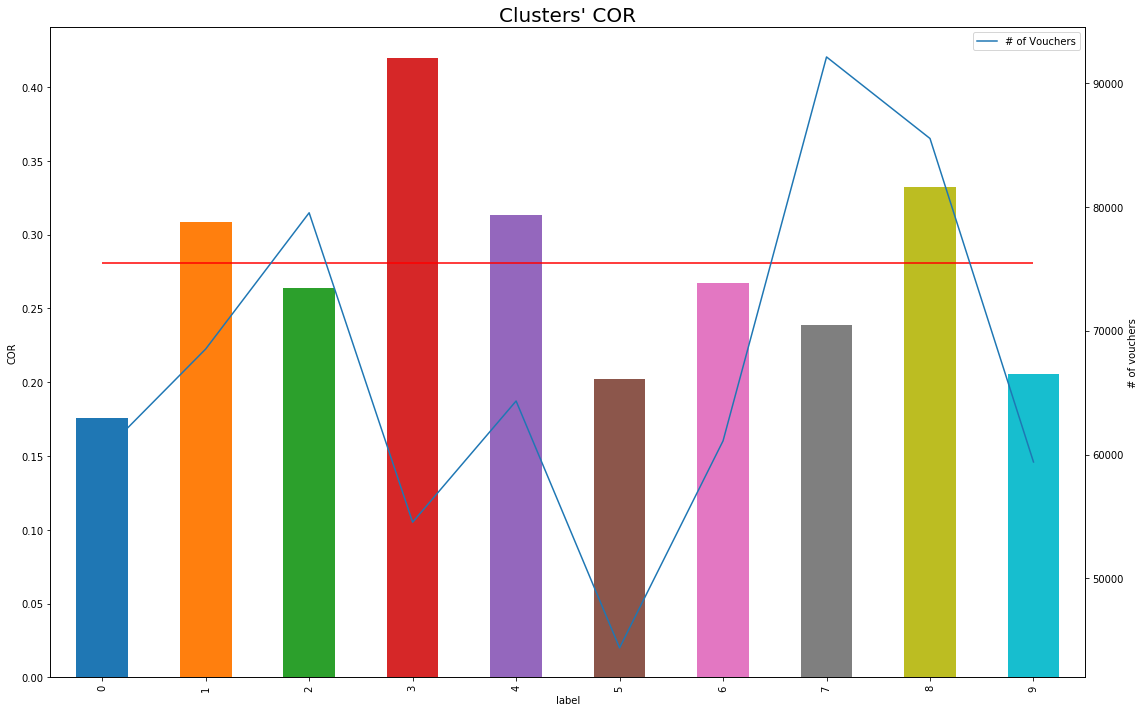

In [16]:
fig, ax = plt.subplots(figsize=(16, 10))
(vou_bin_labelled.groupby('label')['claims_cost'].sum() / vou_bin_labelled.groupby('label')['premium'].sum()).plot(kind='bar', ax=ax, label = '')
ax.hlines(vou_bin_labelled['claims_cost'].sum() / vou_bin_labelled['premium'].sum(), 0, 9, colors='r', label='Mean COR')
ax.set_ylabel('COR')
ax.set_title('Arbitrary Ranges', fontsize=20)

ax2 = ax.twinx()
ax2.set_ylabel('# of vouchers')
(vou_bin_labelled.groupby('label')['n_claims'].count()).plot(kind='line', ax=ax2, label='# of Vouchers')
ax2.legend()

fig.tight_layout();
# fig.savefig('./reports/figures/COR.png');

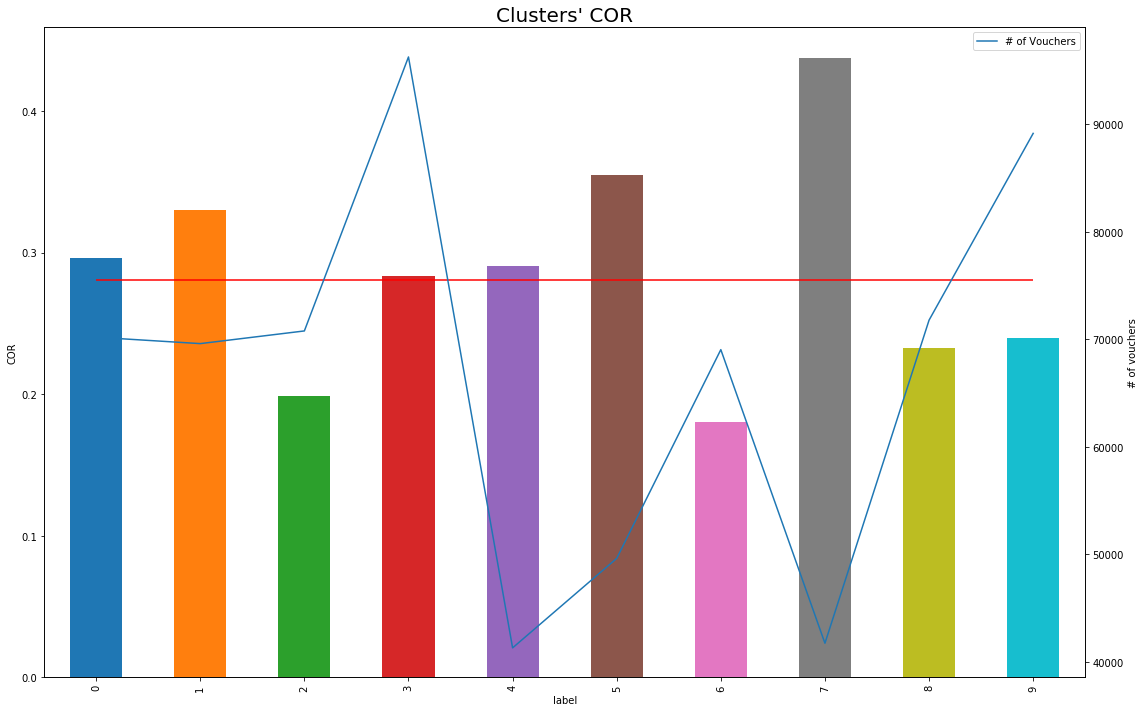

In [17]:
fig, ax = plt.subplots(figsize=(16, 10))
(vou_quant_labelled.groupby('label')['claims_cost'].sum() / vou_quant_labelled.groupby('label')['premium'].sum()).plot(kind='bar', ax=ax, label = '')
ax.hlines(vou_quant_labelled['claims_cost'].sum() / vou_quant_labelled['premium'].sum(), 0, 9, colors='r', label='Mean COR')
ax.set_ylabel('COR')
ax.set_title('Quantiles\' Ranges', fontsize=20)

ax2 = ax.twinx()
ax2.set_ylabel('# of vouchers')
(vou_quant_labelled.groupby('label')['n_claims'].count()).plot(kind='line', ax=ax2, label='# of Vouchers')
ax2.legend()

fig.tight_layout();
# fig.savefig('./reports/figures/COR_quant.png');

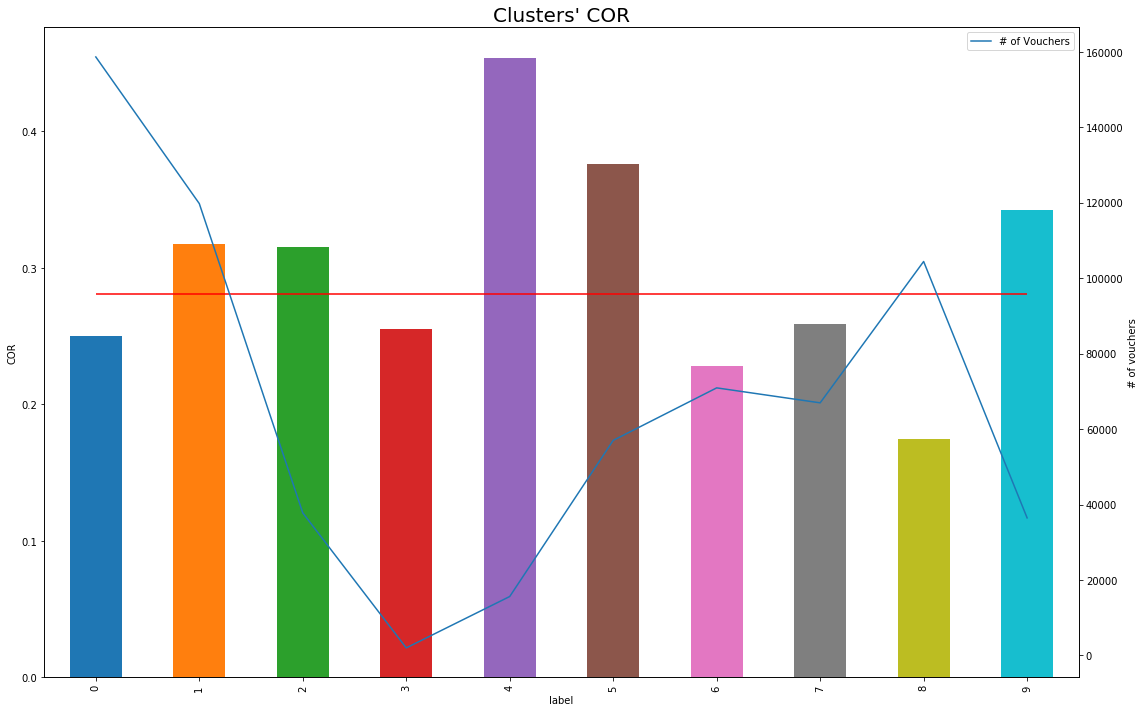

In [18]:
fig, ax = plt.subplots(figsize=(16, 10))
(vou_bin_all_labelled.groupby('label')['claims_cost'].sum() / vou_bin_all_labelled.groupby('label')['premium'].sum()).plot(kind='bar', ax=ax, label = '')
ax.hlines(vou_bin_all_labelled['claims_cost'].sum() / vou_bin_all_labelled['premium'].sum(), 0, 9, colors='r', label='Mean COR')
ax.set_ylabel('COR')
ax.set_title('Arbitrary Ranges and Series\' Data', fontsize=20)

ax2 = ax.twinx()
ax2.set_ylabel('# of vouchers')
(vou_bin_all_labelled.groupby('label')['n_claims'].count()).plot(kind='line', ax=ax2, label='# of Vouchers')
ax2.legend()

fig.tight_layout();
# fig.savefig('./reports/figures/COR_all.png');

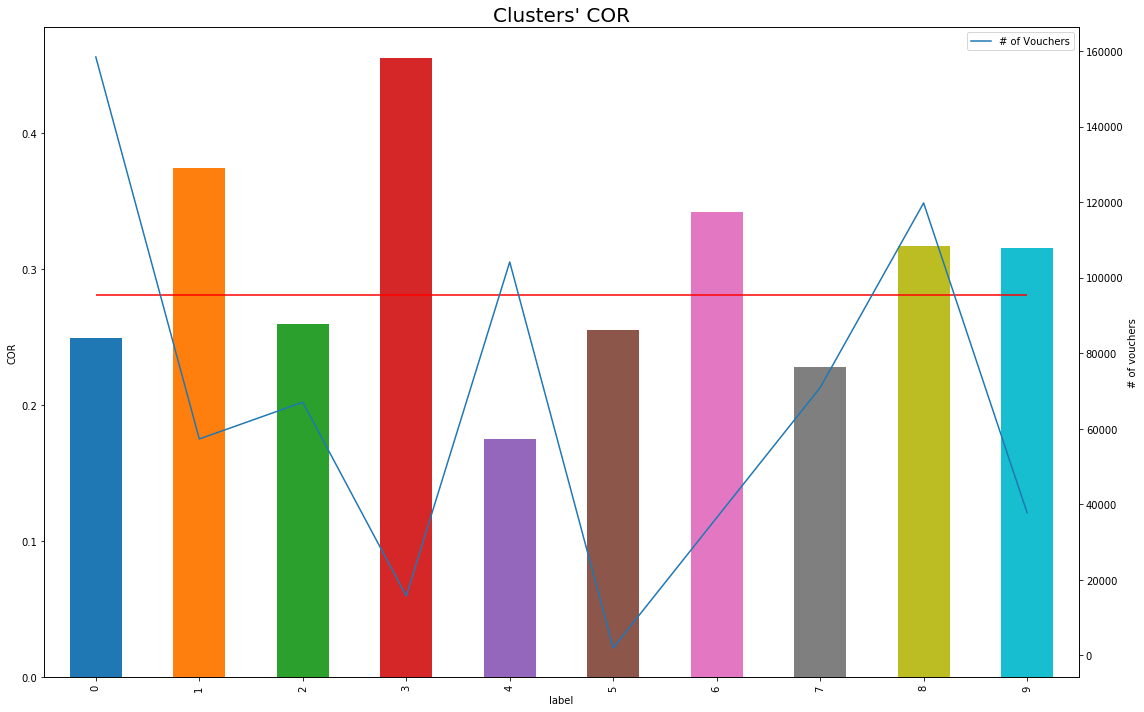

In [19]:
fig, ax = plt.subplots(figsize=(16, 10))
(vou_quant_all_labelled.groupby('label')['claims_cost'].sum() / vou_quant_all_labelled.groupby('label')['premium'].sum()).plot(kind='bar', ax=ax, label = '')
ax.hlines(vou_quant_all_labelled['claims_cost'].sum() / vou_quant_all_labelled['premium'].sum(), 0, 9, colors='r', label='Mean COR')
ax.set_ylabel('COR')
ax.set_title('Quantiles\' Ranges and Series\' Data', fontsize=20)

ax2 = ax.twinx()
ax2.set_ylabel('# of vouchers')
(vou_quant_all_labelled.groupby('label')['n_claims'].count()).plot(kind='line', ax=ax2, label='# of Vouchers')
ax2.legend()

fig.tight_layout();
# fig.savefig('./reports/figures/COR_quant_all.png');

Inspecting each plot I think the best clustering is the second one, which was obtained using only apriori features obtained from ranges determined using quantiles: this clustering has a cluster with a very high COR (number 7) and, on the other side, a couple ones with very low CORs (6 and 3).

In [13]:
vou_quant_labelled.to_pickle('./data/processed/final_clustering.pkl')

## Following Notebooks

- [Interpreting Clusters](5-Interpreting_Clusters.ipynb)